Reference tutorial: [Link](https://www.tensorflow.org/tutorials/structured_data/time_series)

### Useful imports and setup

In [193]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Load data

In [194]:
DATA_PATH = '../data/extract.txt'

cols_map = {
    "DTS": "crossTime",
    #"LANE": "lane",
    #"DIR": "direction",
    "SPD": "speed",
    "AX": "nAxles",
    "GW_TOT": "weight",
    "TYPE": "type",
}

data = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
data.rename(columns=cols_map, inplace=True)
# Parse crossTime column as datetime object
data.crossTime = pd.to_datetime(data.crossTime, format="%Y%m%dT%H%M%S")
# Convert type column to <category> object
data['type'] = data.type.astype('category')

data.head()

,crossTime,speed,nAxles,weight,type
0,2000-01-04 00:05:57,101,2,17930,11
1,2000-01-04 00:28:24,83,2,5230,11
2,2000-01-04 00:34:57,84,2,8310,11
3,2000-01-04 01:14:14,89,2,7550,11
4,2000-01-04 02:25:26,104,3,20930,12


### Data description

In [195]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
speed,9999.0,88.238024,7.028601,21.0,85.0,88.0,89.0,184.0
nAxles,9999.0,3.225723,1.111846,2.0,2.0,3.0,4.0,8.0
weight,9999.0,12335.469547,6135.098224,3500.0,7630.0,11440.0,15630.0,52440.0


### Feature engineering
- Datetime column `crossTime` not useful in its string form. We extract time of day, time of the week, and/or time of the year information to analyse periodicity.

In [196]:
# Transform to seconds
timestamp_s = data.crossTime.map(pd.Timestamp.timestamp)

# Corresponding length in seconds for day, week, year
minute_s = 60
hour_s = minute_s * 60
day_s = 24 * hour_s # 24h x 60m x 60s
week_s = 7 * day_s
year_s = 365.2425 * day_s

In [197]:
def add_time_period_cols(time_length, time_string):
    data[time_string + '_sin'] = np.sin(timestamp_s * (2 * np.pi / time_length))
    data[time_string + '_cos'] = np.cos(timestamp_s * (2 * np.pi / time_length))
    
add_time_period_cols(day_s, 'day')
add_time_period_cols(week_s, 'week')

Text(0.5, 1.0, 'Sin transformed time signal')

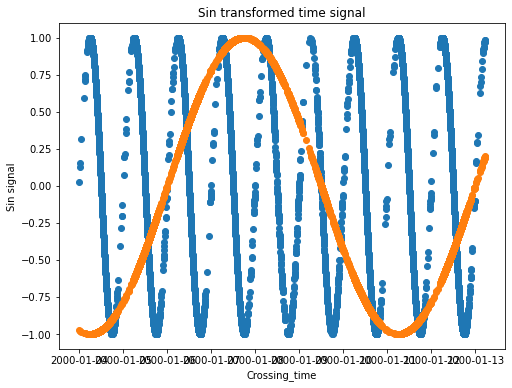

In [198]:
plt.scatter(y=np.array(data['day_sin']), x=data['crossTime'])
plt.scatter(y=np.array(data['week_sin']), x=data['crossTime'])
plt.ylabel('Sin signal')
plt.xlabel('Crossing_time')
plt.title('Sin transformed time signal')

As shown above, we obtain a nice periodic signal with respect to the time of day, time of week, and time of year.

### Split data

In [199]:
y, X = data['crossTime'], data.drop(['crossTime', 'type'], axis=1).copy()

column_indices = {name: i for i, name in enumerate(X.columns)}

n = len(X.index)
train_data = X[0:int(n*0.7)]
val_data = X[int(n*0.7):int(n*0.9)]
test_data = X[int(n*0.9):]

n_features = X.shape[1]

In [200]:
train_data.head()

,speed,nAxles,weight,day_sin,day_cos,week_sin,week_cos
0,101,2,17930,0.025959,0.999663,-0.975746,-0.218904
1,83,2,5230,0.123601,0.992332,-0.978714,-0.205228
2,84,2,8310,0.151908,0.988395,-0.979544,-0.201231
3,89,2,7550,0.318270,0.948000,-0.984177,-0.177187
4,104,3,20930,0.592833,0.805325,-0.991069,-0.133348


### Normalize data

In [201]:
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

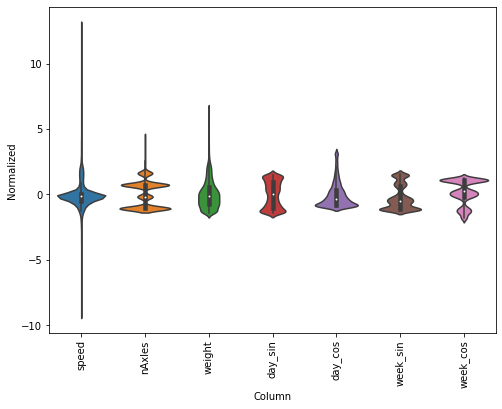

In [202]:
X_std = (X - train_mean) / train_std
X_std = X_std.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=X_std)
_ = ax.set_xticklabels(X.keys(), rotation=90)

### Data windowing

In [203]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=val_data, test_df=test_data,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [204]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['weight'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['weight']

In [205]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['weight'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['weight']

In [206]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [207]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_data[:w2.total_window_size]),
                           np.array(train_data[100:100+w2.total_window_size]),
                           np.array(train_data[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 7)
Inputs shape: (3, 6, 7)
Labels shape: (3, 1, 1)


In [208]:
w2.example = example_inputs, example_labels

In [209]:
def plot(self, model=None, plot_col='weight', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

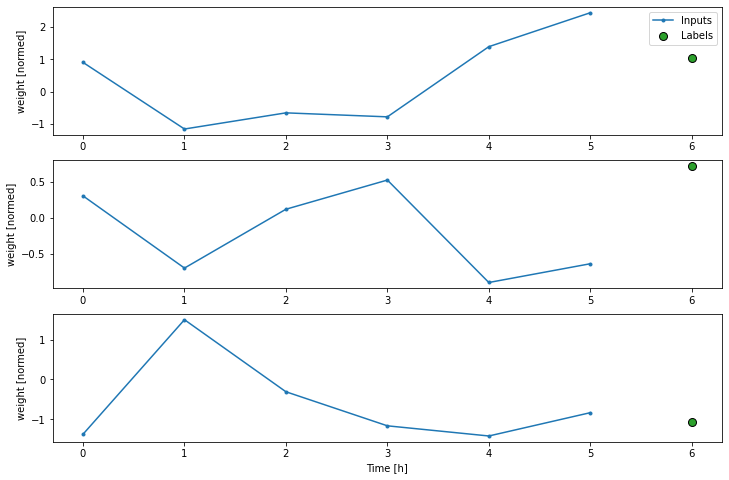

In [210]:
w2.plot()

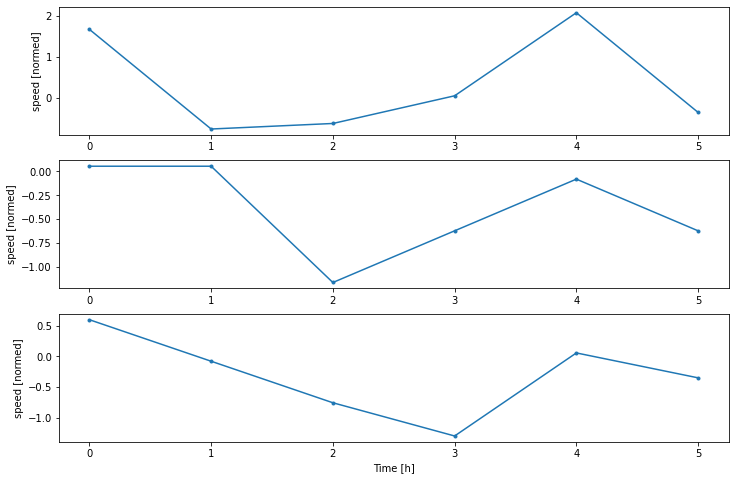

In [211]:
w2.plot(plot_col='speed')

In [212]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds


WindowGenerator.make_dataset = make_dataset


In [213]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [214]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['weight']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['weight']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(TensorSpec(shape=(None, 6, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [215]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 7)
Labels shape (batch, time, features): (32, 1, 1)


### Single step models

In [216]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['weight'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['weight']

In [217]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)


#### Baseline

In [218]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [219]:
baseline = Baseline(label_index=column_indices['weight'])


baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
63/63 [==============================] - 1s 1ms/step - loss: 1.9599 - mean_absolute_error: 1.1169


In [220]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['weight'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['weight']

In [221]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


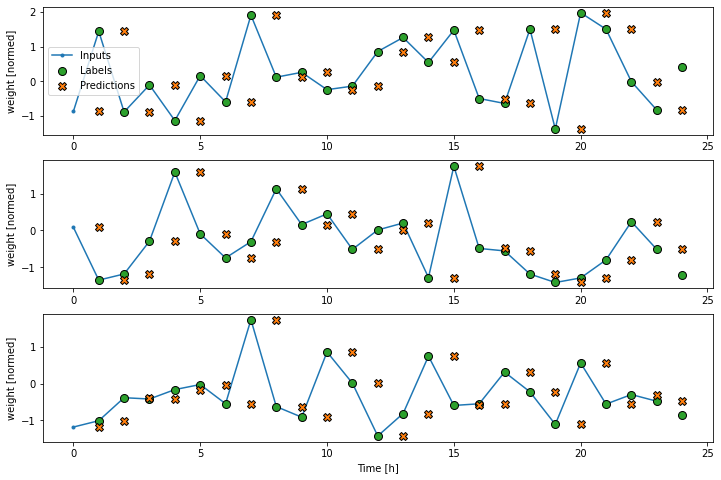

In [222]:
wide_window.plot(baseline)

#### Linear

In [223]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [224]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 7)
Output shape: (32, 1, 1)


In [225]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [226]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 3.2777 - mean_absolute_error: 1.4359 - val_loss: 2.1701 - val_mean_absolute_error: 1.2001
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 2.2469 - mean_absolute_error: 1.1890 - val_loss: 1.6469 - val_mean_absolute_error: 1.0492
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 1.6633 - mean_absolute_error: 1.0254 - val_loss: 1.3587 - val_mean_absolute_error: 0.9528
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 1.3402 - mean_absolute_error: 0.9197 - val_loss: 1.1999 - val_mean_absolute_error: 0.8929
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 1.1500 - mean_absolute_error: 0.8516 - val_loss: 1.1160 - val_mean_absolute_error: 0.8567
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 1.0496 - mean_absolute_error: 0.8123 - val_loss: 1.0738 - val_mean_absolute_error: 0.8357
Epoch 7/20
219/2

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


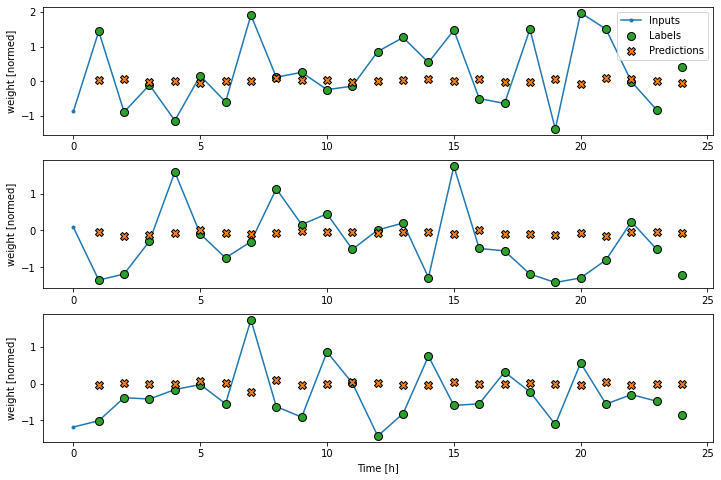

In [227]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

wide_window.plot(linear)

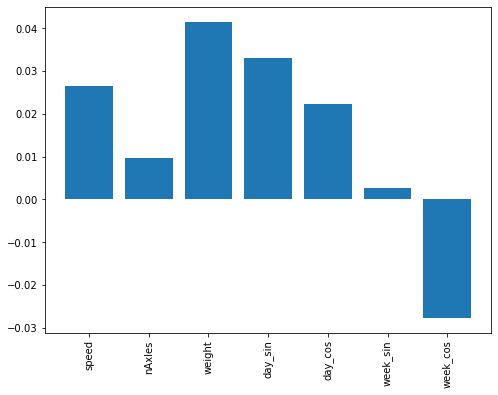

In [228]:
plt.bar(x = range(len(train_data.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_data.columns)))
_ = axis.set_xticklabels(train_data.columns, rotation=90)


#### Dense

In [229]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 1.0074 - mean_absolute_error: 0.7969 - val_loss: 1.0362 - val_mean_absolute_error: 0.8054
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.9774 - mean_absolute_error: 0.7839 - val_loss: 1.0378 - val_mean_absolute_error: 0.8027
Epoch 3/20
63/63 [==============================] - 1s 7ms/step - loss: 1.0375 - mean_absolute_error: 0.8070


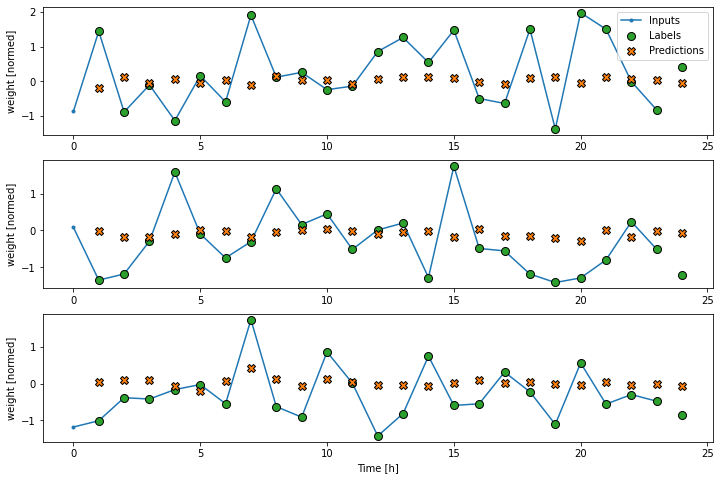

In [230]:
wide_window.plot(dense)

#### Multi step  dense

In [231]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['weight'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['weight']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

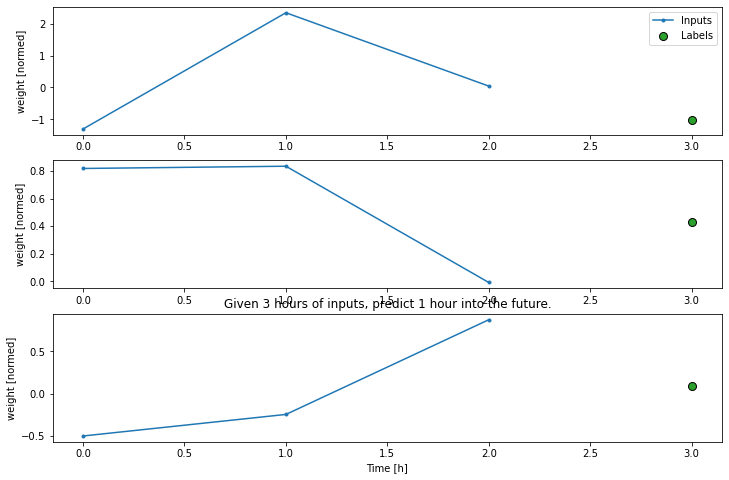

In [232]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")


In [233]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [234]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)


Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


In [235]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

63/63 [==============================] - 1s 6ms/step - loss: 1.0425 - mean_absolute_error: 0.8132


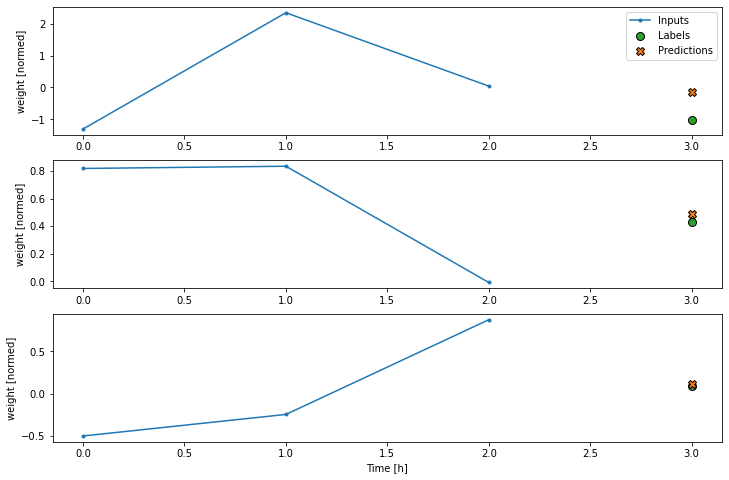

In [236]:
conv_window.plot(multi_step_dense)

#### Convolutional NN

In [238]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [239]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


In [240]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)


63/63 [==============================] - 1s 6ms/step - loss: 1.0461 - mean_absolute_error: 0.8121


In [241]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 7)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [244]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['weight'])

wide_conv_window


Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['weight']

In [245]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


Wide conv window
Input shape: (32, 26, 7)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


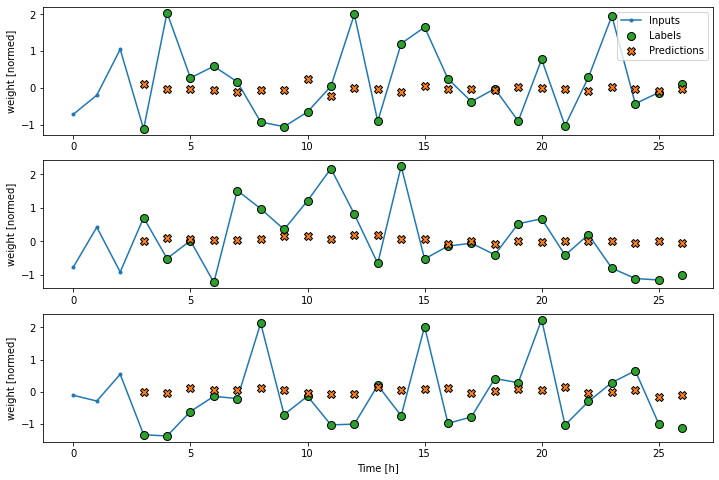

In [246]:
wide_conv_window.plot(conv_model)


#### RNN

In [247]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [248]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)


Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


In [250]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


Epoch 1/20


NotImplementedError: in user code:

    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:389 call
        outputs = layer(inputs, **kwargs)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1157 call
        inputs, initial_state, _ = self._process_inputs(inputs, initial_state, None)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:859 _process_inputs
        initial_state = self.get_initial_state(inputs)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:642 get_initial_state
        init_state = get_initial_state_fn(
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:2506 get_initial_state
        return list(_generate_zero_filled_state_for_cell(
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:2987 _generate_zero_filled_state_for_cell
        return _generate_zero_filled_state(batch_size, cell.state_size, dtype)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:3003 _generate_zero_filled_state
        return nest.map_structure(create_zeros, state_size)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/util/nest.py:659 map_structure
        structure[0], [func(*x) for x in entries],
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/util/nest.py:659 <listcomp>
        structure[0], [func(*x) for x in entries],
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:3000 create_zeros
        return array_ops.zeros(init_state_size, dtype=dtype)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2819 wrapped
        tensor = fun(*args, **kwargs)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2868 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2804 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:5 prod
        
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3030 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /home/luca/anaconda3/envs/ada/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:852 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (sequential_6/lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


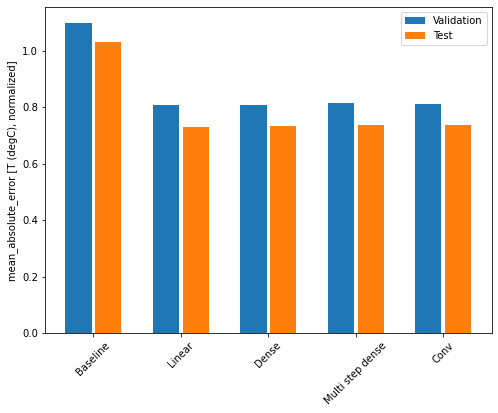

In [253]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = dense.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [254]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


Baseline    : 1.0304
Linear      : 0.7296
Dense       : 0.7329
Multi step dense: 0.7368
Conv        : 0.7384
